In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from os import listdir
%matplotlib inline
from itertools import combinations
import random
from scipy import stats

In [2]:
# Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

# Z coordinates translations
local_z_shifts = [z*ZCELL for z in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]

In [3]:
'''ERRORE SISTEMATICO NEL POSIZIONAMENTO DELLE CAMERE'''

def read_data(event):    
    event_number = int(event[0])
    hits_number  = int(event[1])
    hit       = np.arange(hits_number)
    chamber   = np.fromiter((event[2+5*i] for i in range(hits_number)), int)
    layer     = np.fromiter((event[3+5*i] for i in range(hits_number)), int)
    xl_local  = np.fromiter((event[4+5*i] for i in range(hits_number)), float)
    xr_local  = np.fromiter((event[5+5*i] for i in range(hits_number)), float)
    z_local   = np.fromiter((local_z_shifts[i-1]+ZCELL/2 for i in layer), float)
    time      = np.fromiter((event[6+5*i] for i in range(hits_number)), float)
    xl_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xl_local
    xr_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xr_local
    z_global  = np.fromiter((global_z_shifts[i] for i in chamber), float) + z_local
    dataframe = pd.DataFrame(
        { 'EvNumber' : event_number,
          'Hit'      : hit,
          'Chamber'  : chamber,
          'Layer'    : layer,
          'XL_local' : xl_local,
          'XR_local' : xr_local,
          'Z_local'  : z_local,
          'Time'     : time,
          'XL_global': xl_global,
          'XR_global': xr_global,
          'Z_global' : z_global,
        })
    #dataframe.set_index('Hit', inplace=True) # set as index the number of the hit 
    return dataframe, event_number, hits_number


def select_events(dataframe):
        
        #hits only in the right side
        if((dataframe['Chamber']<=1).all()):
            chambers=[0,1]
            #compute number of different layers in each chamber
            n_layer_ch0 = dataframe[dataframe['Chamber']==0]['Layer'].nunique()
            n_layer_ch1 = dataframe[dataframe['Chamber']==1]['Layer'].nunique()
            
            n_layer=[n_layer_ch0, n_layer_ch1]
            
            #require at least 3 different layers for each chamber
            if(n_layer_ch0>=3 and n_layer_ch1>=3):
                select=True
                return select, chambers, n_layer
            else:
                select=False
                return select, chambers, n_layer
            
        #hits only in the left side
        elif((dataframe['Chamber']>=2).all()):
            chambers=[2,3]
            #compute number of different layers in each chamber
            n_layer_ch2 = dataframe[dataframe['Chamber']==2]['Layer'].nunique()
            n_layer_ch3 = dataframe[dataframe['Chamber']==3]['Layer'].nunique() 
            
            n_layer=[n_layer_ch2, n_layer_ch3]
            
            #require at least 3 different layers for each chamber
            if(n_layer_ch2>=3 and n_layer_ch3>=3):
                select=True
                return select, chambers, n_layer
            else:
                select=False
                return select, chambers, n_layer
        
        #hits in both left and right side
        else:
            select=False
            chambers=[]
            n_layer=[]
            return select, chambers, n_layer 



def local_fit(dataframe, list_chambers, list_layers):
    #list to store results for each chamber
    results=[]
    #loop over the (two) chambers
    for i in range(0,len(list_chambers)):
       #if we have 4 different layers we randomly select a layer to be excluded
       #we will use the point from the excluded layer to check the goodness of the global fit
        if(list_layers[i]==4):
            rand_layer=random.randint(1,4)
        else:
            rand_layer=0 #layers are 1,2,3,4: excluding layer 0 is equivalent to keeping them all
        
        #create dataframe_cl filtered by chamber and excluded layer
        dataframe_c = dataframe[dataframe['Chamber']==list_chambers[i]] #dataframe filtered by chamber
        dataframe_cl = dataframe_c[dataframe_c['Layer']!=rand_layer]    #filtered by chamber and excluded layer
        
        # Z local coordinates corresponding to the 4 different layers
        Z=[6.5,19.5, 32.5, 45.5]
        
        #create a list l containing 3 lists of points (z,x), one for each selected layer
        l=[]
        
        #loop over selected layers and fill l
        for layer_index in dataframe_cl['Layer'].unique():
            XR=np.array(dataframe_cl[dataframe_cl['Layer']==layer_index]['XR_local'])
            XL=np.array(dataframe_cl[dataframe_cl['Layer']==layer_index]['XL_local'])
            
            z=Z[(layer_index-1)] #layer_index is in range [1,4], list index must be in range [0,3]
            l_temp=[]
            
            for x in XR:
                l_temp.append((z,x))
            for x in XL:
                l_temp.append((z,x)) 
            l.append(l_temp) 
            
        #create numpy array with all possible combinations of 3 points p1,p2,p3
        combinations=np.array([(p1,p2,p3) for p1 in l[0] for p2 in l[1] for p3 in l[2]])
        
        #interpolate each combination and select the combination with least chi squared
        min_chisq=100000 #to store minimum chisq
        optimal_comb=np.zeros((3,2)) #to store best combination of points
        slope_opt=0 #to store slope obtained with the best combination
        intercept_opt=0 #to store intercept obtained with the best combination
        for points in combinations:
            #linear regression
            slope, intercept, r_value, p_value, std_err=stats.linregress(points[:,0],points[:,1])
            #compute expected x using the interpolating function
            expect_x=intercept+slope*(points[:,0])
            #compute chi squared
            chisq, p_value=stats.chisquare(points[:,1],expect_x)
            #eventually update min_chisq and optimal_comb
            if(chisq<min_chisq):
                min_chisq=chisq
                optimal_comb=points
                slope_opt=slope
                intercept_opt=intercept
            else:
                continue
                  
        #add to results: results is a list of 2 dictionaries, one for each chamber       
        results.append({"slope":slope_opt, 
                        "intercept":intercept_opt, 
                        "optimal_comb": optimal_comb, 
                        "excl_layer": rand_layer})
                   
    return results






fraction of parallels fit:  1.4649681528662422 %


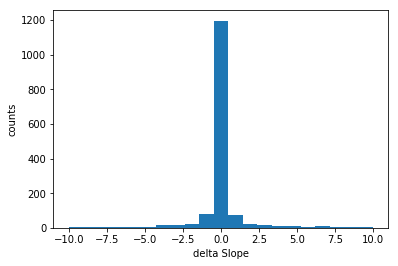

fraction of parallels fit:  1.9002375296912115 %


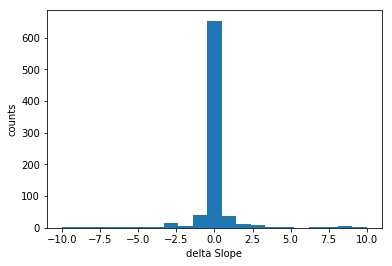

In [4]:
for i in listdir("/Users/federicob/Documents/data/calibration/Run000260"):
    file="/Users/federicob/Documents/data/calibration/Run000260"+"/"+i 
    
    rette_parallele=0
    rette_tot=0
    differenze_pendenze=[]
    with open(file) as f:
        for line in f:
            event = line.split()
            event = [float(i) for i in event]
            
            
            
            dataframe, event_number, hits_number=read_data(event) 
            #print(dataframe)
            
            if select_events(dataframe)[0]==True:
                
                #print(dataframe)# mi sono selezionato gli eventi
                condition, chambers, n_layers=select_events(dataframe)
                #print(chambers,n_layers)
                #print(chambers[0])
                
                '''adesso devo eseguire i local linear fit della camera sopra e della camera sotto'''
                lf_results=local_fit(dataframe, chambers, n_layers)
                sl1=lf_results[0]["slope"]
                sl2=lf_results[1]["slope"]
                differenze_pendenze.append(sl1-sl2)
                rette_tot+=1
                if sl2>=(sl1-(sl1*5)/100) and sl2<=(sl1+(sl1*5)/100):
                    rette_parallele+=1
                
                #print(rette_parallele)
                '''plt.figure()
                if chambers[0]==2:
                    x=np.linspace(-700,-200,100)
                    y=lf_results[0]["slope"]*x+lf_results[0]["intercept"]
                    plt.plot(x,y,color="red")
                    y=lf_results[1]["slope"]*x+lf_results[1]["intercept"]
                    plt.plot(x,y,color="green")
                    
                    
                    
                else:
                    x=np.linspace(200,600,100)
                    y=lf_results[0]["slope"]*x+lf_results[0]["intercept"]
                    plt.plot(x,y,color="red")
                    y=lf_results[1]["slope"]*x+lf_results[1]["intercept"]
                    plt.plot(x,y,color="green")
                    
                plt.show()'''
    frac_par=(rette_parallele/rette_tot)*100
    print("fraction of parallels fit: ",frac_par,"%")        
    plt.figure()
    plt.hist(differenze_pendenze,21, range=[-10,10])
    plt.xlabel('delta Slope')
    plt.ylabel('counts')
    plt.show()

fraction of parallels fit:  0.32441200324412006 %


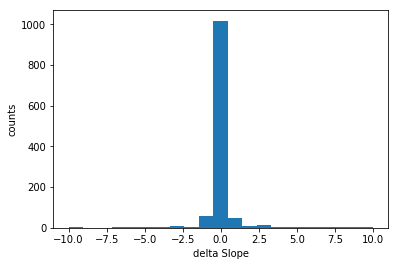

fraction of parallels fit:  0.0 %


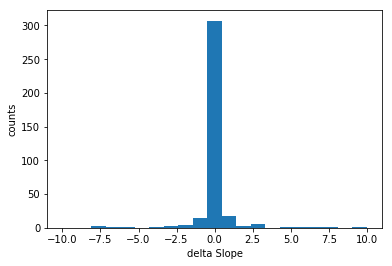

In [5]:
for i in listdir("/Users/federicob/Documents/data/calibration/Run000261"):
    file="/Users/federicob/Documents/data/calibration/Run000261"+"/"+i 
    
    rette_parallele=0
    rette_tot=0
    differenze_pendenze=[]
    with open(file) as f:
        for line in f:
            event = line.split()
            event = [float(i) for i in event]
            
            
            
            dataframe, event_number, hits_number=read_data(event) 
            #print(dataframe)
            
            if select_events(dataframe)[0]==True:
                
                #print(dataframe)# mi sono selezionato gli eventi
                condition, chambers, n_layers=select_events(dataframe)
                #print(chambers,n_layers)
                #print(chambers[0])
                
                '''adesso devo eseguire i local linear fit della camera sopra e della camera sotto'''
                lf_results=local_fit(dataframe, chambers, n_layers)
                sl1=lf_results[0]["slope"]
                sl2=lf_results[1]["slope"]
                differenze_pendenze.append(sl1-sl2)
                rette_tot+=1
                if sl2>=(sl1-(sl1*5)/100) and sl2<=(sl1+(sl1*5)/100):
                    rette_parallele+=1
                #print(rette_parallele)
                '''plt.figure()
                if chambers[0]==2:
                    x=np.linspace(-700,-200,100)
                    y=lf_results[0]["slope"]*x+lf_results[0]["intercept"]
                    plt.plot(x,y,color="red")
                    y=lf_results[1]["slope"]*x+lf_results[1]["intercept"]
                    plt.plot(x,y,color="green")
                    
                    
                    
                else:
                    x=np.linspace(200,600,100)
                    y=lf_results[0]["slope"]*x+lf_results[0]["intercept"]
                    plt.plot(x,y,color="red")
                    y=lf_results[1]["slope"]*x+lf_results[1]["intercept"]
                    plt.plot(x,y,color="green")
                    
                plt.show()'''
    frac_par=(rette_parallele/rette_tot)*100
    print("fraction of parallels fit: ",frac_par,"%") 
    plt.figure()
    plt.hist(differenze_pendenze,21, range=[-10,10])
    plt.xlabel('delta Slope')
    plt.ylabel('counts')
    plt.show()

fraction of parallels fit:  7.37913486005089 %


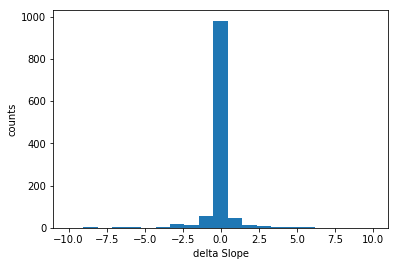

fraction of parallels fit:  9.833024118738404 %


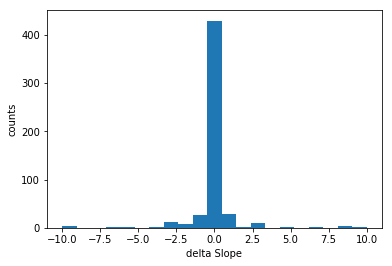

In [6]:
for i in listdir("/Users/federicob/Documents/data/calibration/Run000262"):
    file="/Users/federicob/Documents/data/calibration/Run000262"+"/"+i 
    
    rette_parallele=0
    rette_tot=0
    differenze_pendenze=[]
    with open(file) as f:
        for line in f:
            event = line.split()
            event = [float(i) for i in event]
            
            
            
            dataframe, event_number, hits_number=read_data(event) 
            #print(dataframe)
            
            if select_events(dataframe)[0]==True:
                
                #print(dataframe)# mi sono selezionato gli eventi
                condition, chambers, n_layers=select_events(dataframe)
                #print(chambers,n_layers)
                #print(chambers[0])
                
                '''adesso devo eseguire i local linear fit della camera sopra e della camera sotto'''
                lf_results=local_fit(dataframe, chambers, n_layers)
                sl1=lf_results[0]["slope"]
                sl2=lf_results[1]["slope"]
                differenze_pendenze.append(sl1-sl2)
                rette_tot+=1
                if sl2>=(sl1-(sl1*5)/100) and sl2<=(sl1+(sl1*5)/100):
                    rette_parallele+=1
                #print(rette_parallele)
                '''plt.figure()
                if chambers[0]==2:
                    x=np.linspace(-700,-200,100)
                    y=lf_results[0]["slope"]*x+lf_results[0]["intercept"]
                    plt.plot(x,y,color="red")
                    y=lf_results[1]["slope"]*x+lf_results[1]["intercept"]
                    plt.plot(x,y,color="green")
                    
                    
                    
                else:
                    x=np.linspace(200,600,100)
                    y=lf_results[0]["slope"]*x+lf_results[0]["intercept"]
                    plt.plot(x,y,color="red")
                    y=lf_results[1]["slope"]*x+lf_results[1]["intercept"]
                    plt.plot(x,y,color="green")
                    
                plt.show()'''
    frac_par=(rette_parallele/rette_tot)*100
    print("fraction of parallels fit: ",frac_par,"%") 
    plt.figure()
    plt.hist(differenze_pendenze,21, range=[-10,10])
    plt.xlabel('delta Slope')
    plt.ylabel('counts')
    plt.show()

fraction of parallels fit:  5.934718100890208 %


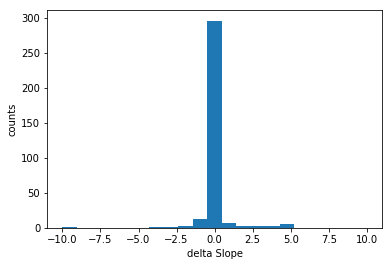

fraction of parallels fit:  0.0 %


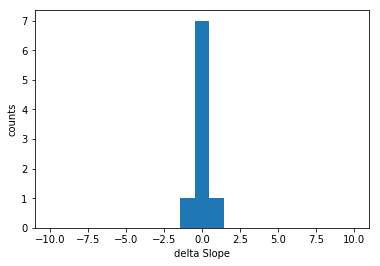

In [7]:
for i in listdir("/Users/federicob/Documents/data/calibration/Run000263"):
    file="/Users/federicob/Documents/data/calibration/Run000263"+"/"+i 
    
    rette_parallele=0
    rette_tot=0
    differenze_pendenze=[]
    with open(file) as f:
        for line in f:
            event = line.split()
            event = [float(i) for i in event]
            
            
            
            dataframe, event_number, hits_number=read_data(event) 
            #print(dataframe)
            
            if select_events(dataframe)[0]==True:
                
                #print(dataframe)# mi sono selezionato gli eventi
                condition, chambers, n_layers=select_events(dataframe)
                #print(chambers,n_layers)
                #print(chambers[0])
                
                '''adesso devo eseguire i local linear fit della camera sopra e della camera sotto'''
                lf_results=local_fit(dataframe, chambers, n_layers)
                sl1=lf_results[0]["slope"]
                sl2=lf_results[1]["slope"]
                differenze_pendenze.append(sl1-sl2)
                rette_tot+=1
                if sl2>=(sl1-(sl1*5)/100) and sl2<=(sl1+(sl1*5)/100):
                    rette_parallele+=1
                #print(rette_parallele)
                '''plt.figure()
                if chambers[0]==2:
                    x=np.linspace(-700,-200,100)
                    y=lf_results[0]["slope"]*x+lf_results[0]["intercept"]
                    plt.plot(x,y,color="red")
                    y=lf_results[1]["slope"]*x+lf_results[1]["intercept"]
                    plt.plot(x,y,color="green")
                    
                    
                    
                else:
                    x=np.linspace(200,600,100)
                    y=lf_results[0]["slope"]*x+lf_results[0]["intercept"]
                    plt.plot(x,y,color="red")
                    y=lf_results[1]["slope"]*x+lf_results[1]["intercept"]
                    plt.plot(x,y,color="green")
                    
                plt.show()'''
    frac_par=(rette_parallele/rette_tot)*100
    print("fraction of parallels fit: ",frac_par,"%") 
    plt.figure()
    plt.hist(differenze_pendenze,21, range=[-10,10])
    plt.xlabel('delta Slope')
    plt.ylabel('counts')
    plt.show()